## 吴恩达机器学习习题八：异常检测<br><br>
- 检测异常服务器

![](./IMG_3380.JPG)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.io as sio

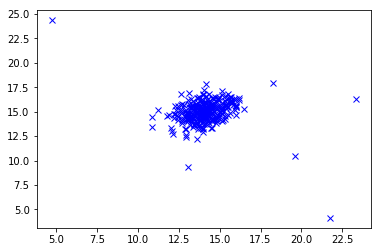

In [2]:
#读取数据&数据可视化
data = sio.loadmat('data/ex8data1.mat')
X_train = data['X']  #(307,2)
X_val = data['Xval']  #(307,2)
y_val = data['yval']  #(307,1)
plt.plot(X_train[:,0],X_train[:,1],'bx')
plt.show()

In [3]:
#获取训练集中的均值和方差
def estimateGaussian(X,isCovariance):
    
    X_mean = np.mean(X,axis=0)  # (1,2),按列求均值
    if isCovariance:  #(多元高斯分布)
        sigma = (X-X_mean).T @ (X-X_mean) / len(X)  #(2,2)
    else:  #(原始高斯分布)
        sigma = np.var(X,axis=0)  #(1,2)求方差，按列
    return X_mean,sigma

In [4]:
#高斯分布函数
def gaussian(X,means,sigma):
    
    if np.ndim(sigma) == 1:  #np.ndim判断矩阵为几维。向量为一维，矩阵为二维，若有3个[]，即为3维
        sigma = np.diag(sigma)  #若为一维，则生成一个以一维数组为对角线元素的矩阵；二维则输出对角线元素
    n = X.shape[1]
    first = np.power(2*np.pi,-n/2) * (np.linalg.det(sigma)**(-0.5))  #np.linalg.det求矩阵的行列式，**的意思是次方
    second = np.diag((X-means)@(np.linalg.inv(sigma))@(X-means).T)
    P = first * np.exp(-0.5*second)
    P = P.reshape((-1,1))   #(任意行，1)
    return P   #(307,1)

In [5]:
#画图
def plotGaussian(X,means,sigma):
    
    x = np.arange(0, 30, 0.5) 
    y = np.arange(0, 30, 0.5)
    xx, yy = np.meshgrid(x,y)  
    z= gaussian(np.c_[xx.flatten(),yy.flatten()], means, sigma)  # 计算对应的高斯分布函数
    zz = z.reshape(xx.shape)  
    plt.plot(X[:,0],X[:,1],'bx')
    contour_levels = [10**h for h in range(-20,0,3)]
    plt.contour(xx, yy, zz, contour_levels)

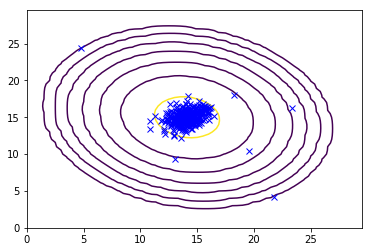

In [6]:
#使用多元高斯分布
means,sigma1 = estimateGaussian(X_train,isCovariance = True)
plotGaussian(X_train,means,sigma1)

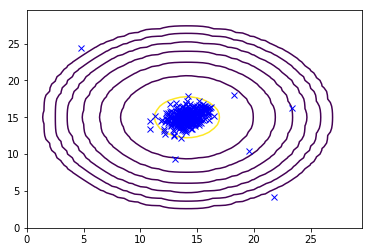

In [7]:
#使用原始高斯分布
means,sigma2 = estimateGaussian(X_train,isCovariance = False)
plotGaussian(X_train,means,sigma2)

In [8]:
#选择阈值
def select_threshold(y_val,p):
    
    best_threshold = 0
    best_F1 = 0
    times = np.linspace(min(p),max(p),1000)
    for i in times:
        p1 = p < i
        tp = np.sum((y_val==1)&(p1==1))   #等于1为异常（少数）
        fp = np.sum((y_val==0)&(p1==1))
        fn = np.sum((y_val==1)&(p1==0))
        if (tp+fp) != 0:
            chazhun = tp/(tp+fp)
        else:
            chazhun=0
        if (tp+fn) != 0:
            chaquan = tp/(tp+fn)
        else:
            chaquan = 0
        if (chaquan+chazhun) != 0:
            score = 2*chaquan*chazhun/(chaquan+chazhun)
        else:
            score = 0
        if score > best_F1:
            best_threshold = i
            best_F1 = score
    return best_threshold,best_F1

In [10]:
means,sigma1 = estimateGaussian(X_train,isCovariance = True)
p1 = gaussian(X_val,means,sigma1)
threshold,F1 = select_threshold(y_val,p1)
print(threshold)

(307, 1)
[9.07484457e-05]


In [ ]:
p2 = gaussian(X_train,means,sigma1)
anoms = np.array([X_train[i] for i in range(X_train.shape[0]) if p2[i] <threshold])
plotGaussian(X_train,means,sigma1)
plt.scatter(anoms[:,0],anoms[:,1],c='red',marker='o')